# XRD analysis of samples MAPbX3 samples


In [99]:
#   Import Necessary Packages and Define Functions

import glob
import pandas as pd
import plotly.express as px
import numpy as np
import math
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.sparse import linalg
from numpy.linalg import norm
import matplotlib.pyplot as plt

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def trim_data(x,data,limit1,limit2):
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2]

def twotheta_to_q(angle, lam = 1.54060):
  angle_rad = angle/2*np.pi/180
  return 4*np.pi*np.sin(angle_rad)/lam

def gaussian(x, a, b, c): 
    #generic gaussian curve, for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a*np.exp(-(x - b)**2/(2*c**2))

def normal_gaussian(x, a, b): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the peak position and 
    #b is the FWHM
    return 2/b*sqrt(ln(2)/math.pi)*np.exp(-4*ln(2)/b**2*(x - a)**2)

def two_gaussians(x, a1, b1, c1, a2, b2, c2):
        return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2))

def multi_gaussian(x, guesses):
    #NOTE This function does not work with curve fitting yet TBD
    # x is 1D array of 2-theta or q values for our fitting
    # trips is an array of fits i.e. [[200, 1, .01], [150, 1.05. .02]]
    peaks = [gaussian(x, fit[0], fit[1], fit[2]) for fit in guesses]
    return np.sum(peaks, axis=0)

# Define three peak fitting
def three_gaussians(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2)+ #this would be your initial peak center in Q
            gaussian(x, a3, b3, c3))
            
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)

def double_pvoigt(x, e, a1, b1, c1, a2, b2, c2):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g1 = c1/(2*np.sqrt(2*np.log(2)))
    c_g2 = c2/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a1, b1, c1) + (1-e)*normal_gaussian(x,a1,b1,c_g1) + e*lorentz(x, a2, b2, c2) + (1-e)*normal_gaussian(x,a2,b2,c_g2)

def baseline_als(y, lam, p, niter=10):
  #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

def xrd_basic(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic1(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),13,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic_q(data):
  chem = pd.read_csv(data,header = None, names=None)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),41,2)
  chem_np[:,0] = twotheta_to_q(chem_np[:,0])
  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def xrd_focus(data,limit1,limit2):
  chem = pd.read_fwf(data, colspecs='infer', skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus1(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**7, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus_q(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**7, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),31,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  q_cut = twotheta_to_q(theta_cut)
  chem_cut = np.column_stack((q_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def cubic_lattice(twotheta, miller):
  return 1.5406*math.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)/(2*math.sin(twotheta*math.pi/180/2))

def xrd_fit(dataset,limit1,limit2):
  #   Do a curve fit
  chem_np = np.array(dataset)
  peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
  p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
  upper_limit = [1, 3000, limit2, 2]
  lower_limit = [0, 0, limit1, 0]
  popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
  chem_out = np.column_stack((chem_np,pvoigt(chem_np[:,0],*popt),chem_np[:,1]/np.max(chem_np[:,1])))
  chem_fit = pd.DataFrame(chem_out)
  chem_fit.columns = ["2Theta","Intensity","Fit", "Norm_Inten"]
  return popt, pcov, chem_fit

path = r'XRD_data/center'
all_files = sorted(glob.glob(path+"/*.plt"))
limit1 = 10
limit2 =45
print(all_files)

['XRD_data/center/chem01_centerslice.plt', 'XRD_data/center/chem02_centerslice.plt', 'XRD_data/center/chem03_center.plt', 'XRD_data/center/chem04_full.plt', 'XRD_data/center/chem05_center.plt', 'XRD_data/center/chem06_center.plt', 'XRD_data/center/chem07_center.plt', 'XRD_data/center/chem08_center.plt', 'XRD_data/center/chem09_center.plt', 'XRD_data/center/chem10_center.plt', 'XRD_data/center/chem11_center.plt', 'XRD_data/center/chem12_center.plt', 'XRD_data/center/chem13_center.plt', 'XRD_data/center/chem14_center.plt', 'XRD_data/center/chem15_take2_centerslice.plt', 'XRD_data/center/chem16_take2_centerslice.plt']


In [87]:
# Import Chemistry Information

chems = pd.read_csv('XRD_data/ML_import.csv',skipfooter=5)
print(chems)


    Chemistry    Cl     I    Br  Predicted Lattice      [100]      [110]  \
0           1  0.10  0.79  0.11           6.189745  14.297732  20.273216   
1           2  0.66  0.09  0.25           5.796186  15.274148  21.665855   
2           3  0.83  0.07  0.10           5.749627  15.398579  21.843444   
3           4  0.17  0.59  0.24           6.097984  14.514030  20.581580   
4           5  0.32  0.42  0.26           5.999566  14.753436  20.922977   
5           6  0.49  0.26  0.25           5.899074  15.006198  21.283524   
6           7  0.00  0.50  0.50           6.102000  14.504428  20.567889   
7           8  0.50  0.00  0.50           5.798500  15.268016  21.657103   
8           9  0.50  0.50  0.00           5.988500  14.780850  20.962076   
9          10  0.33  0.33  0.34           5.962490  14.845691  21.054559   
10         11  0.45  0.40  0.15           5.961850  14.847293  21.056845   
11         12  0.28  0.60  0.12           6.076440  14.565769  20.655353   
12         1

/Users/rbelisle/opt/anaconda3/envs/wellesolar/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


# Import Standards

In [7]:

limit1 = 10
limit2 = 40
MAPbI3 = pd.read_csv('/Users/rbelisle/Desktop/FAPbX3 Data/MAPbI3.txt',delimiter='\t')
MAPbI3.columns = ["2Theta", "Intensity"]
chem_np = np.array(MAPbI3)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
MAPbI3 = pd.DataFrame(chem_cut)
MAPbI3.columns = ["2Theta","Intensity"]

MAPbBr3 = pd.read_csv('/Users/rbelisle/Desktop/FAPbX3 Data/MAPbBr3.txt',delimiter='\t')
MAPbBr3.columns = ["2Theta", "Intensity"]
chem_np = np.array(MAPbBr3)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
MAPbBr3 = pd.DataFrame(chem_cut)
MAPbBr3.columns = ["2Theta","Intensity"]



FileNotFoundError: [Errno 2] No such file or directory: '/Users/rbelisle/Desktop/FAPbX3 Data/MAPbI3.txt'

# Specific Chem

IndexError: list index out of range

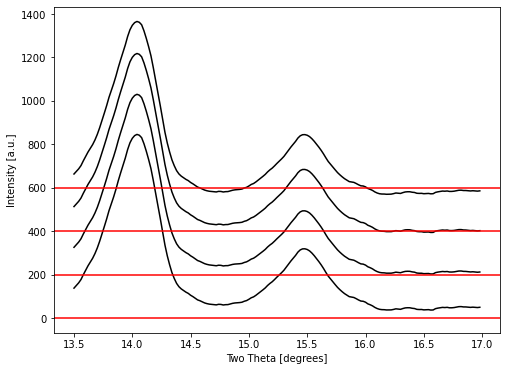

In [97]:
#   Import and process data

fig2, ax2 = plt.subplots(figsize=(8,6))
shift = 200

test = [10**4, 10**5,10**6,10**7,10**8]
test2 = [.0001, .001, .01, .1]
limit1 = 13.5
limit2 = 17
j = 8
for i in range(0,len(test)):
    def xrd_focus1(data,limit1,limit2):
        chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]

        chem_np = np.array(chem)
        back = baseline_als(chem_np[:,1], 10**7, test2[i])
        chem_np[:,1] = savgol_filter((chem_np[:,1]-back),15,2)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        return chem_out

    sample0 = xrd_focus1(all_files[j],limit1,limit2)

    #   Plot curve and fit
    ax2.plot(sample0["2Theta"],sample0["Intensity"]+shift*i,'k-')
    ax2.axhline(shift*i, color='red')

    #ax2.plot(MAPbBr3["2Theta"],MAPbBr3["Intensity"]/10+shift*1,'b-')
    #ax2.plot(MAPbI3["2Theta"],MAPbI3["Intensity"]/10,'r-')
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')

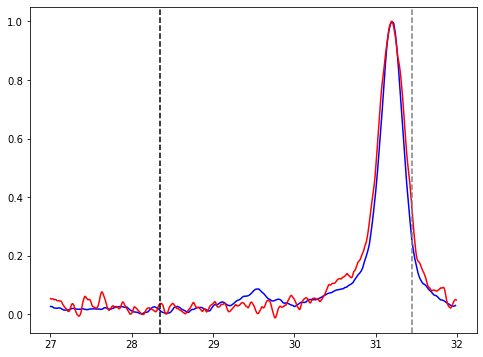

In [106]:
#  Center vs. Full
fig2, ax2 = plt.subplots(figsize=(8,6))
limit1 = 27  
limit2 = 32
j = 2
path = r'XRD_data/center'
all_files = sorted(glob.glob(path+"/*.plt"))
sample_center = xrd_focus1(all_files[j],limit1,limit2)

path = r'XRD_data'
all_files = sorted(glob.glob(path+"/*.plt"))
sample_full = xrd_focus1(all_files[j],limit1,limit2)

ax2.plot(sample_center["2Theta"],sample_center["Intensity"]/np.max(sample_center["Intensity"]),'b-')
ax2.plot(sample_full["2Theta"],sample_full["Intensity"]/np.max(sample_full["Intensity"]),'r-')
ax2.axvline(28.34601012, color = "black",linestyle = 'dashed')
ax2.axvline(31.44682976, color = "grey",linestyle = 'dashed')

Chemistry             7.000000
Cl                    0.000000
I                     0.500000
Br                    0.500000
Predicted Lattice     6.102000
[100]                14.504428
[110]                20.567889
[200]                29.247989
[012]                32.792083
Name: 6, dtype: float64


Text(0, 0.5, 'Intensity [a.u.]')

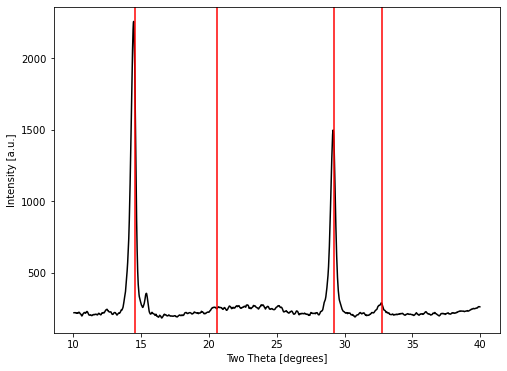

In [102]:
#   Import and process data

fig2, ax2 = plt.subplots(figsize=(8,6))
shift = 100

i = 6
sample0 = xrd_focus1(all_files[i],limit1,limit2)
print(chems.iloc[i])

#   Plot curve and fit
ax2.plot(sample0["2Theta"],sample0["Intensity"]+shift*2,'k-')
ax2.axvline(chems.iloc[i]['[100]'], color = "red")
ax2.axvline(chems.iloc[i]['[110]'], color = "red")
ax2.axvline(chems.iloc[i]['[200]'], color = "red")
ax2.axvline(chems.iloc[i]['[012]'], color = "red")

#ax2.plot(MAPbBr3["2Theta"],MAPbBr3["Intensity"]/10+shift*1,'b-')
#ax2.plot(MAPbI3["2Theta"],MAPbI3["Intensity"]/10,'r-')
ax2.set_xlabel('Two Theta [degrees]')
ax2.set_ylabel('Intensity [a.u.]')


# Survey of all compositions

Text(0, 0.5, 'Normalized Intensity [a.u.]')

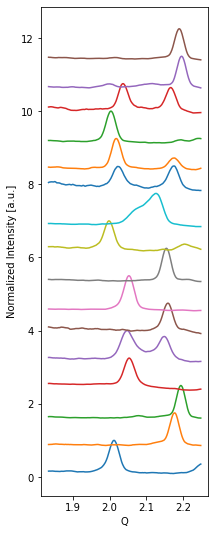

In [32]:
fig1, ax1 = plt.subplots(figsize=(3,9))

shift = .75
limit1 = 26
limit2 = 32

for i in range(0,len(all_files)):
    current = xrd_focus_q(all_files[i],limit1,limit2)
    ax1.plot(current["Q"],current["Intensity"]/np.max(current["Intensity"])+shift*i)

ax1.set_xlabel("Q")
ax1.set_ylabel('Normalized Intensity [a.u.]')
    

# Pull Lattice Constant [100]

0 Single Phase 0.11812425072517331 6.261644014236013
1 Single Phase 0.07598996927522221 5.78934053711674
2 Single Phase 0.15549315027824262 5.747198104473236
3 Single Phase 0.09449868473601632 6.131429185136528
4 Double Phase 0.0483975269294819 6.138216892176131 5.871100415254884
5 Single Phase 0.126700724246551 5.836829292111837
6 Single Phase 0.13522904181000012 6.1421155842101305
7 Single Phase 0.1348046839744478 5.853605357883212
8 Double Phase 0.09184253176003726 5.723203118031092 6.316178755839387
9 Single Phase 0.12078136029265163 5.964897796077503
10 Double Phase 0.065917901526338 5.806676831154009 6.216917602550173
11 Double Phase 0.08347928404312173 6.243262827412662 5.799847440076968
12 Double Phase 0.09039637269609219 6.294388135272491 5.763538318762139
13 Double Phase 0.0757383382661836 5.822083899956354 6.169277296644975
14 Single Phase 0.11431684646487923 5.736743512803759
15 Single Phase 0.08471186753285195 5.754432712072188


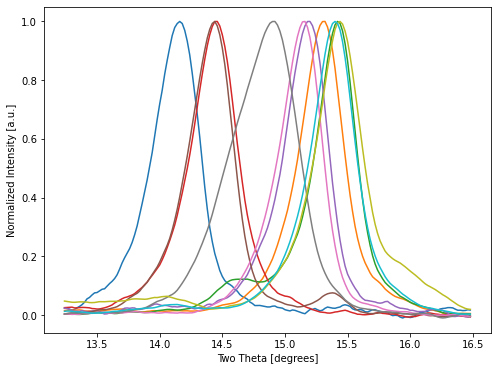

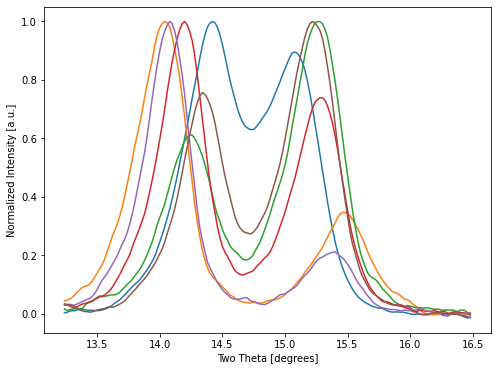

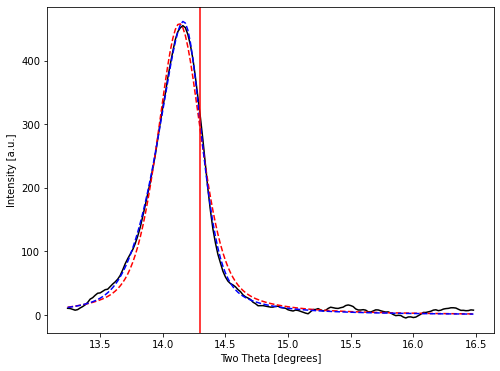

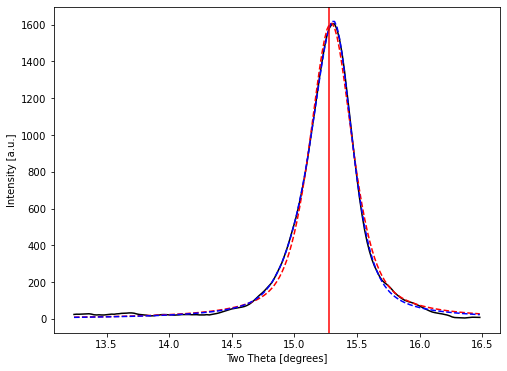

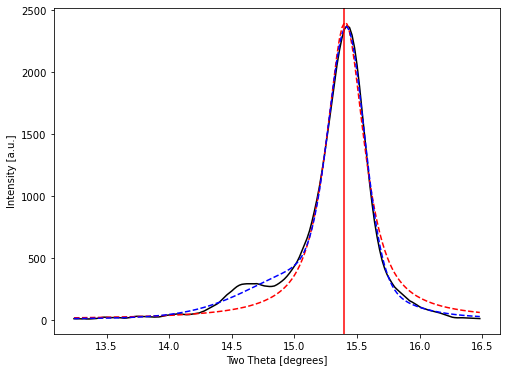

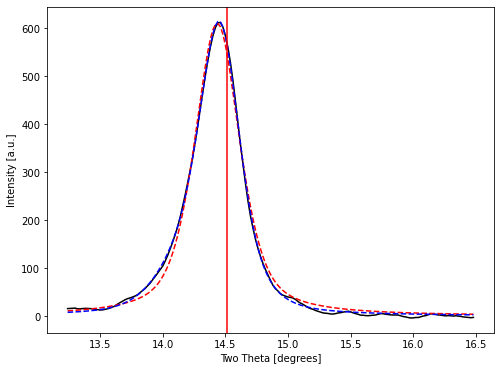

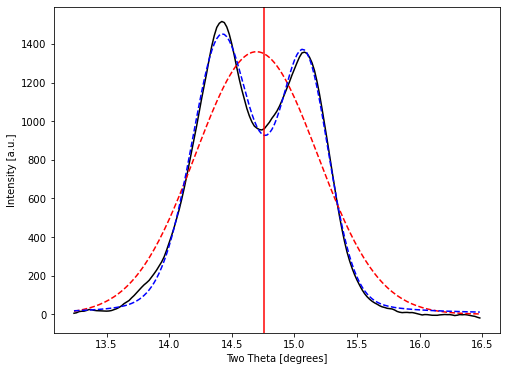

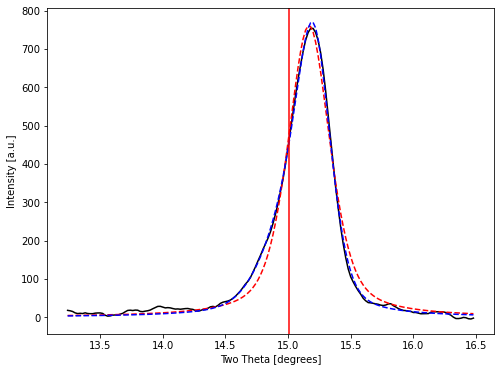

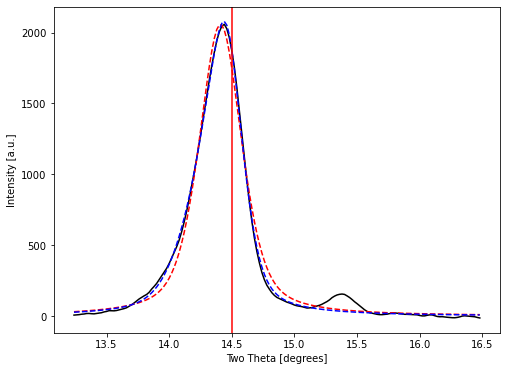

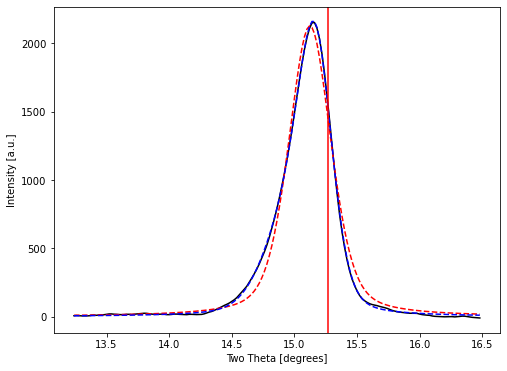

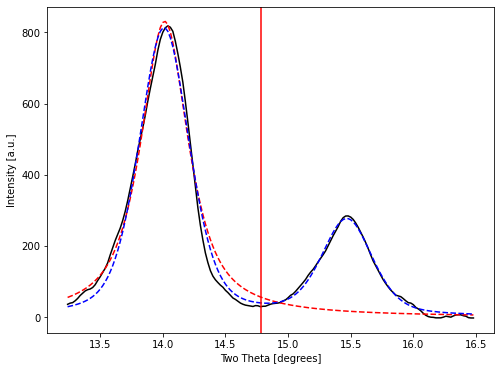

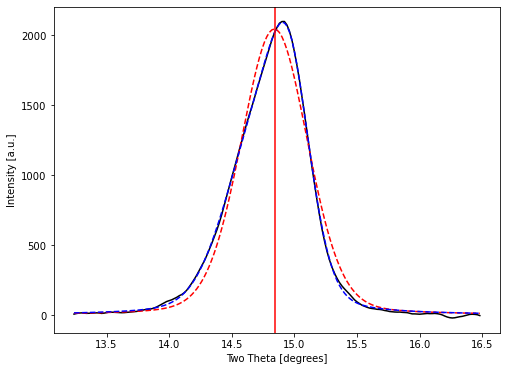

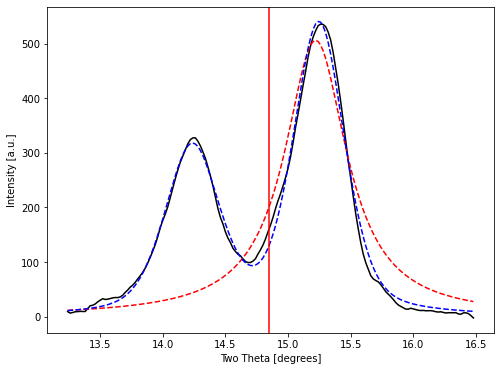

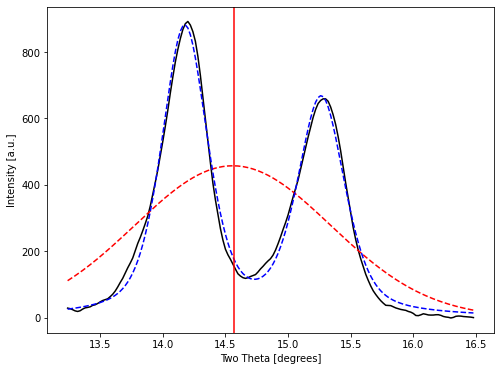

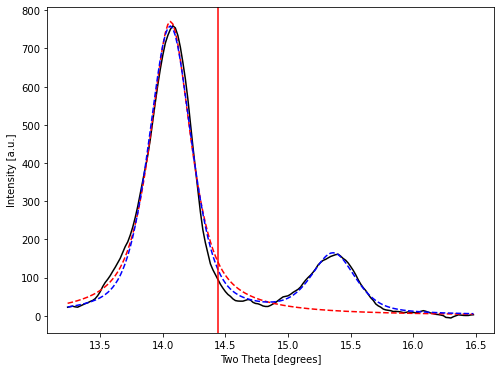

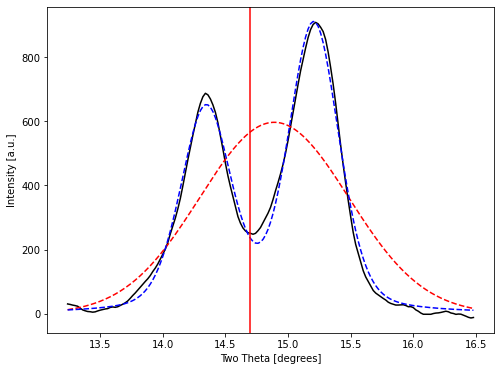

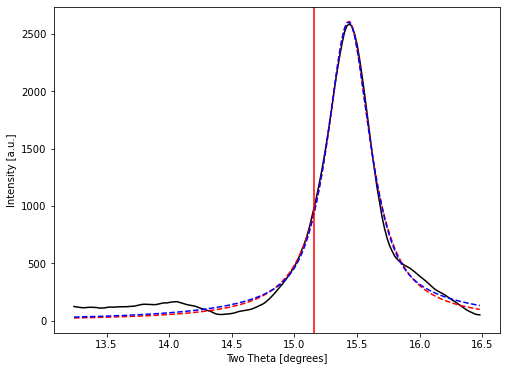

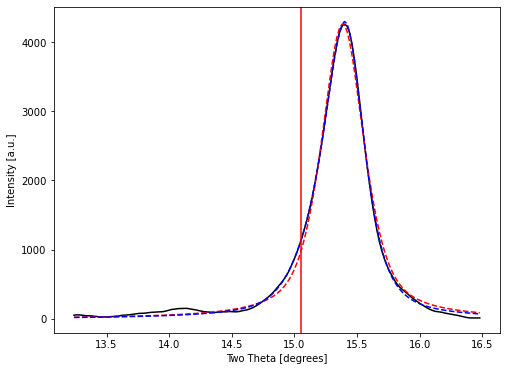

In [96]:
fig3, ax3 = plt.subplots(figsize=(8,6))
fig4, ax4 = plt.subplots(figsize=(8,6))
lattice1 = []
lattice2 = []
fwhm = []
delta = []

for i in range(0,len(all_files)):
    

    #   Set limits in two theta
    limit1 = 13.25
    limit2 = 16.5


    sample = xrd_focus1(all_files[i],limit1,limit2)
    #print(chems.iloc[i])

    #   Fit to a single pseudovoight
    chem_np = np.array(sample)
    #peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    peak = chems.iloc[i]['[100]']
    p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0]
    popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    delta.append(np.abs(peak-chems.iloc[i]['[100]']))
    fwhm.append(popt[-1])

    #   Fit to a double pseudovoight
    chem_np = np.array(sample)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    p0 = [0.2, np.max(chem_np[:,0]), peak-.5, .1, np.max(chem_np[:,0]), peak+.5, .1,] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0,  0, limit1, 0]
    popt2, pcov2 = curve_fit(double_pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt2)


    if np.abs(popt2[2]-popt2[5])<0.5:
        residual = np.sum(np.abs(sample["Intensity"]-pvoigt(sample["2Theta"],*popt)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Single Phase', residual, cubic_lattice(popt[2],[1,0,0]))
        ax3.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]))
        lattice1.append(cubic_lattice(popt[2],[1,0,0]))
        lattice2.append(0)

    else:
        residual = np.sum(np.abs(sample["Intensity"]-double_pvoigt(sample["2Theta"],*popt2)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Double Phase',residual, cubic_lattice(popt2[2],[1,0,0]),cubic_lattice(popt2[5],[1,0,0]))
        ax4.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]))
        lattice1.append(cubic_lattice(popt2[2],[1,0,0]))
        lattice2.append(cubic_lattice(popt2[5],[1,0,0]))
    
    #   Plot curve and fit
    fig2, ax2 = plt.subplots(figsize=(8,6))
    ax2.plot(sample["2Theta"],sample["Intensity"],'k-')
    ax2.plot(sample["2Theta"],pvoigt(sample["2Theta"],*popt),'r--')
    ax2.plot(sample["2Theta"],double_pvoigt(sample["2Theta"],*popt2),'b--')
    ax2.axvline(chems.iloc[i]['[100]'], color = "red")
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')

    ax3.set_xlabel('Two Theta [degrees]')
    ax3.set_ylabel('Normalized Intensity [a.u.]')
    #fig3.savefig("XRD_Data/single.png")

    ax4.set_xlabel('Two Theta [degrees]')
    ax4.set_ylabel('Normalized Intensity [a.u.]')
    #fig4.savefig("XRD_Data/double.png")



No handles with labels found to put in legend.


XRD_data
0 Single Phase 0.27075510341856157 3.123609578366178
1 Double Phase 0.17785460150332244 3.238683114796148 2.8879414472772247
2 Double Phase 0.14369875912659874 2.865078906312917 3.253606972081842
3 Single Phase 0.09047936095769785 3.0596246880545217
4 Double Phase 0.16248645098451103 3.065818232124334 2.9268791350565926
5 Single Phase 0.22577645150262304 2.9116988934793953
6 Single Phase 0.1150596289538502 3.061311934540326
7 Single Phase 0.15796400402511654 2.9171515742160805
8 Double Phase 0.11113059431982439 3.144009546770816 2.829963739624992
9 Double Phase 0.15918849818407993 2.9644235037487636 3.29970142596366
10 Double Phase 0.21086563671134523 3.104219342879054 2.891128672267814
11 Double Phase 0.17104250725170245 3.1133022991071373 2.8876592593578345
12 Single Phase 0.3669059063459416 3.135586502274297
13 Double Phase 0.16187061082834947 3.083877043171082 2.90099946187434
14 Double Phase 0.17696651203436228 3.1411788698763345 2.8628737353883595
15 Double Phase 0.13093

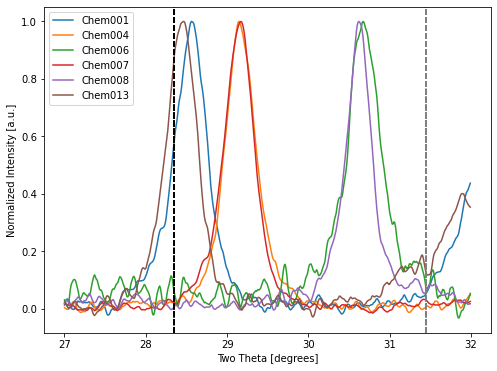

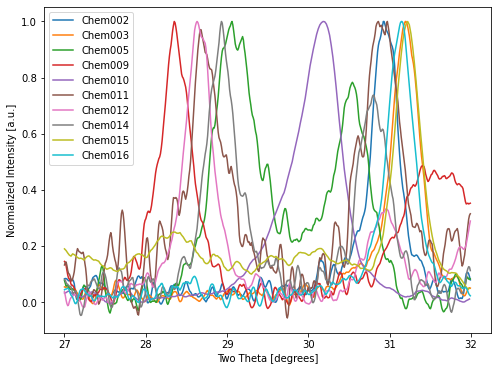

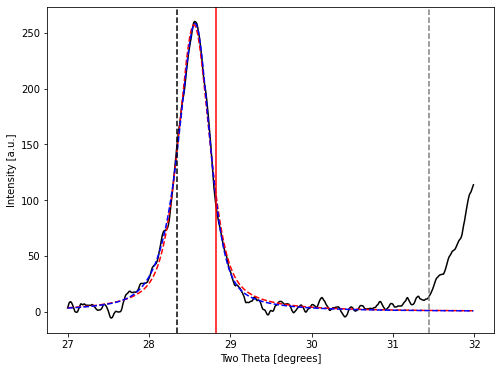

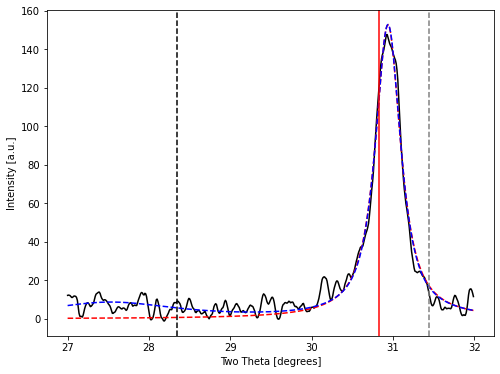

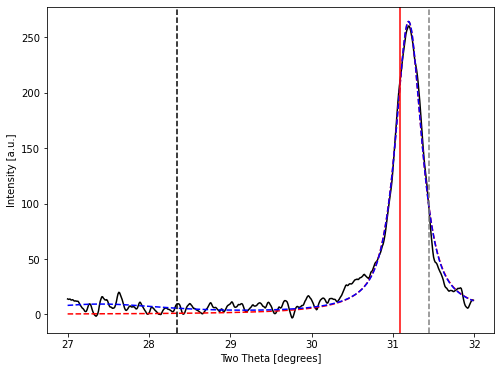

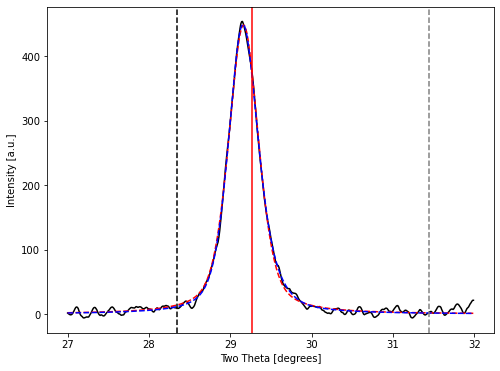

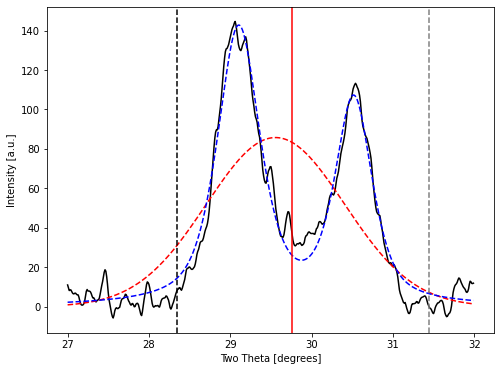

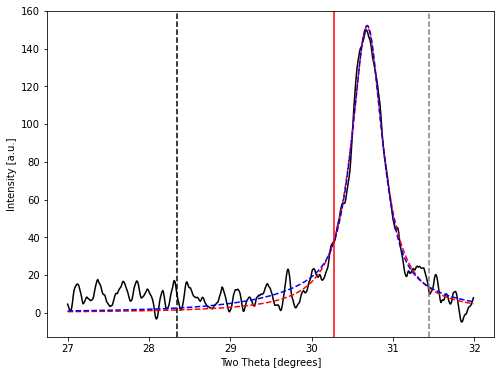

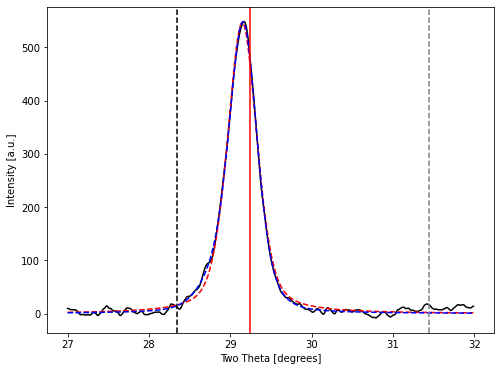

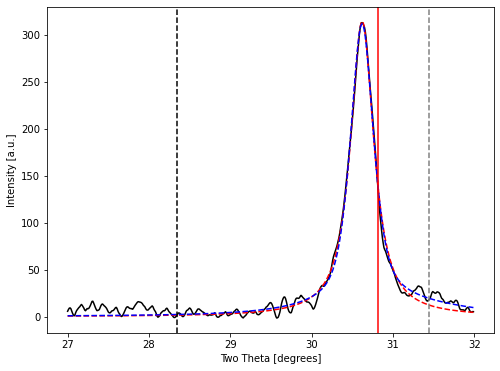

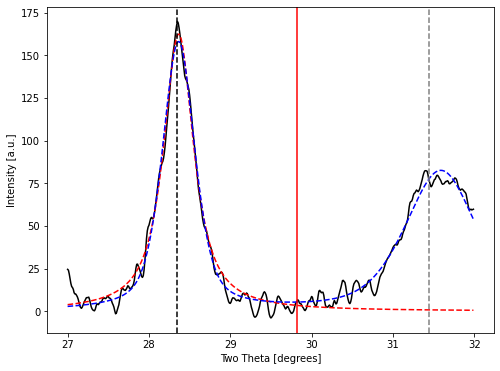

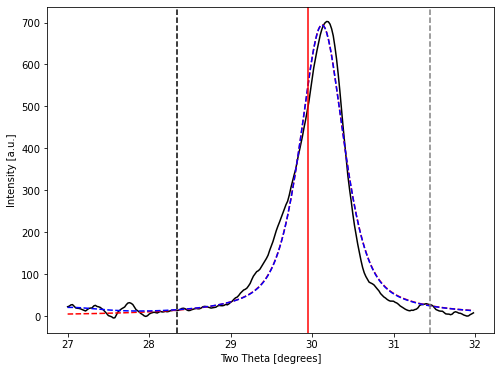

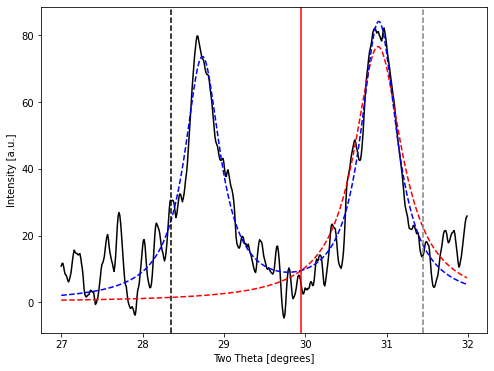

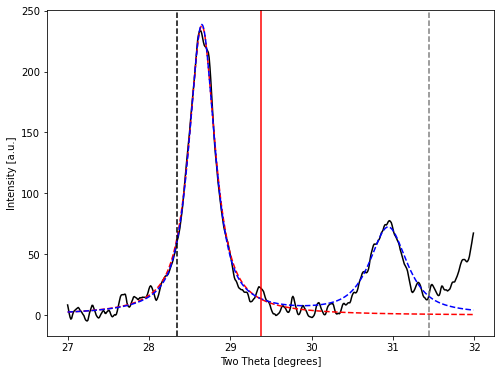

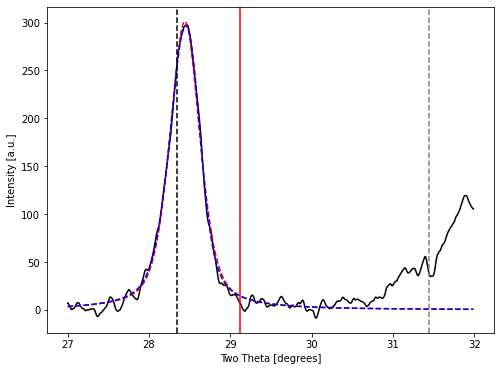

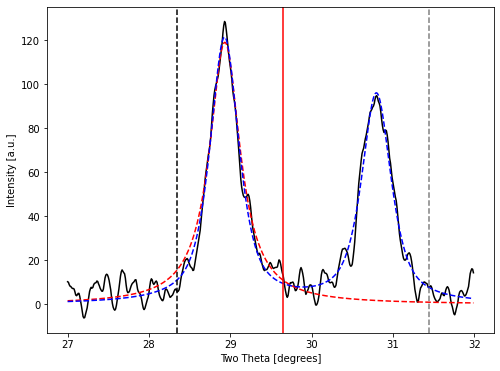

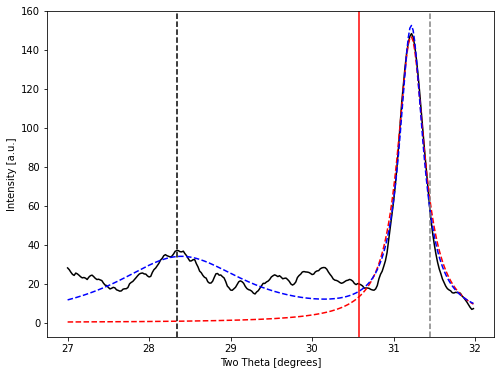

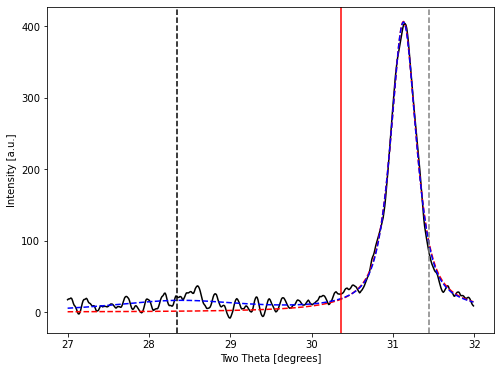

In [79]:
print(path)
fig3, ax3 = plt.subplots(figsize=(8,6))
fig4, ax4 = plt.subplots(figsize=(8,6))
lattice1 = []
lattice2 = []
fwhm = []
delta = []

for i in range(0,len(all_files)):
    

    #   Set limits in two theta
    limit1 = 27
    limit2 = 32


    sample = xrd_focus1(all_files[i],limit1,limit2)
    #print(chems.iloc[i])

    #   Fit to a single pseudovoight
    chem_np = np.array(sample)
    #peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    peak = chems.iloc[i]['[200]']
    p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0]
    popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    delta.append(np.abs(peak-chems.iloc[i]['[200]']))
    fwhm.append(popt[-1])

    #   Fit to a double pseudovoight
    chem_np = np.array(sample)
    peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
    p0 = [0.2, np.max(chem_np[:,0]), peak-.5, .1, np.max(chem_np[:,0]), peak+.5, .1,] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
    upper_limit = [1, 3000, limit2, 2, 3000, limit2, 2]
    lower_limit = [0, 0, limit1, 0,  0, limit1, 0]
    popt2, pcov2 = curve_fit(double_pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
    #print(popt2)


    if np.abs(popt2[2]-popt2[5])<0.5:
        residual = np.sum(np.abs(sample["Intensity"]-pvoigt(sample["2Theta"],*popt)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Single Phase', residual, cubic_lattice(popt[2],[1,0,0]))
        ax3.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]),label = 'Chem' + all_files[i].split('_')[-1].split('.')[0])
        lattice1.append(cubic_lattice(popt[2],[1,0,0]))
        lattice2.append(0)

    else:
        residual = np.sum(np.abs(sample["Intensity"]-double_pvoigt(sample["2Theta"],*popt2)))/np.sum(np.abs(sample["Intensity"]))
        print(i, 'Double Phase',residual, cubic_lattice(popt2[2],[1,0,0]),cubic_lattice(popt2[5],[1,0,0]))
        ax4.plot(sample["2Theta"],sample["Intensity"]/np.max(sample["Intensity"]),label = 'Chem' + all_files[i].split('_')[-1].split('.')[0])
        lattice1.append(cubic_lattice(popt2[2],[1,0,0]))
        lattice2.append(cubic_lattice(popt2[5],[1,0,0]))

    #   Plot curve and fit
    fig2, ax2 = plt.subplots(figsize=(8,6))
    ax2.plot(sample["2Theta"],sample["Intensity"],'k-')
    ax2.plot(sample["2Theta"],pvoigt(sample["2Theta"],*popt),'r--')
    ax2.plot(sample["2Theta"],double_pvoigt(sample["2Theta"],*popt2),'b--')
    ax2.axvline(chems.iloc[i]['[200]'], color = "red")
    ax2.set_xlabel('Two Theta [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')
    ax2.axvline(28.34601012, color = "black",linestyle = 'dashed')
    ax2.axvline(31.44682976, color = "grey",linestyle = 'dashed')

    ax3.legend()
    ax3.set_xlabel('Two Theta [degrees]')
    ax3.set_ylabel('Normalized Intensity [a.u.]')
    ax3.axvline(28.34601012, color = "black",linestyle = 'dashed')
    ax3.axvline(31.44682976, color = "grey",linestyle = 'dashed')
    #fig3.savefig("XRD_Data/single.png")

    ax4.legend()
    ax4.set_xlabel('Two Theta [degrees]')
    ax4.set_ylabel('Normalized Intensity [a.u.]')
    #fig4.savefig("XRD_Data/double.png")



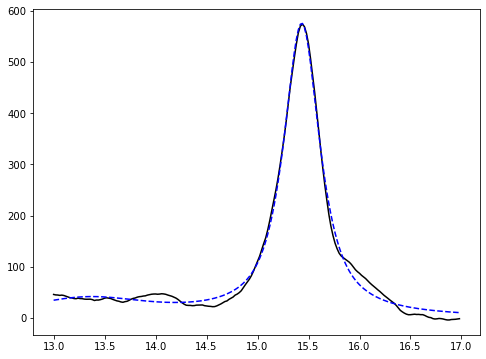

In [20]:
# Repeat analysis of chemistries 15 and 16
#   Set limits in two theta
limit1 = 13
limit2 = 17


sample = xrd_focus1(all_files[14],limit1,limit2)

#   Fit to a double pseudovoight
chem_np = np.array(sample)
p0 = [0.2, np.max(chem_np[:,0]), 15.5, .1, 75, 14.0, .1,] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
upper_limit = [1, 3000, limit2, 2, 3000, limit2, 2]
lower_limit = [0, 0, limit1, 0,  0, limit1, 0]
popt2, pcov2 = curve_fit(double_pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
#print(popt2)

fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.plot(sample["2Theta"],sample["Intensity"],'k-')
ax2.plot(sample["2Theta"],double_pvoigt(sample["2Theta"],*popt2),'b--')


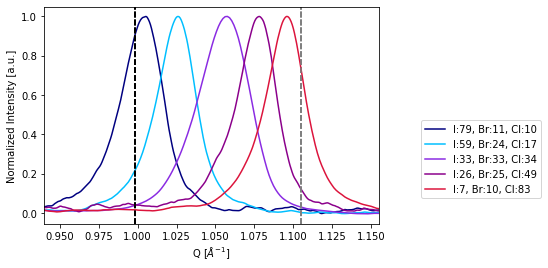

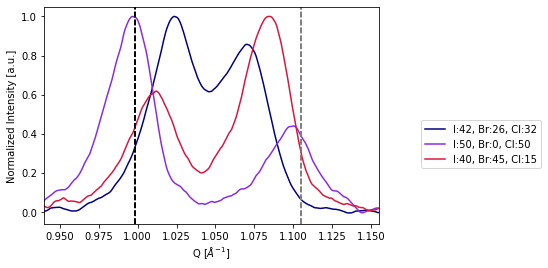

In [10]:
# XRD Figure

fig5, ax5 = plt.subplots(figsize=(6,4))
fig6, ax6 = plt.subplots(figsize=(6,4))
single_chemistries = [1, 4, 10, 6, 3]
double_chemistries = [5,9,11]
limit1 = 17
limit2 = 16.5
colors = ['navy',  'deepskyblue', 'blueviolet', 'darkmagenta', 'crimson']
colors2 = ['navy',   'blueviolet',  'crimson']

labels_sing = ['I:79, Br:11, Cl:10', 'I:59, Br:24, Cl:17','I:33, Br:33, Cl:34','I:26, Br:25, Cl:49', 'I:7, Br:10, Cl:83' ]
labels_doub = ['I:42, Br:26, Cl:32', 'I:50, Br:0, Cl:50','I:40, Br:45, Cl:15']

for i in range(0,len(single_chemistries)):
    current = xrd_focus_q(all_files[single_chemistries[i]-1],limit1,limit2)
    ax5.plot(current["Q"],current["Intensity"]/np.max(current["Intensity"]),color = colors[i], label = labels_sing[i])
    ax5.axvline(0.9985, color = "black",linestyle = 'dashed')
    ax5.axvline(1.1052, color = "grey",linestyle = 'dashed')

ax5.set_xlim([0.94, 1.155])
ax5.set_xlabel("Q [$\AA^{-1}$]")
ax5.set_ylabel('Normalized Intensity [a.u.]')
ax5.legend(loc='upper right', bbox_to_anchor=(1.5, 0.5))

for i in range(0,len(double_chemistries)):
    current = xrd_focus_q(all_files[double_chemistries[i]-1],limit1,limit2)
    ax6.plot(current["Q"],current["Intensity"]/np.max(current["Intensity"]),color = colors2[i], label = labels_doub[i])
    ax6.axvline(0.9985, color = "black",linestyle = 'dashed')
    ax6.axvline(1.1052, color = "grey",linestyle = 'dashed')

ax6.set_xlim([0.94, 1.155])
ax6.set_xlabel("Q [$\AA^{-1}$]")
ax6.set_ylabel('Normalized Intensity [a.u.]')
ax6.legend(loc='upper right', bbox_to_anchor=(1.5, 0.5))

fig5.savefig('images/single_phase.png',dpi = 300)
fig6.savefig('images/double_phase.png', dpi=300)


In [ ]:
# XRD Stress Figure

In [28]:
#   Build csv for data
lattice1 = np.array(lattice1)
lattice2 = np.array(lattice2)
chems_np = np.array(chems)
delta_np = np.array(delta)
fwhm_np = np.array(fwhm)

data = np.column_stack((chems_np,lattice1,lattice2,delta,fwhm))
data = pd.DataFrame(data)
print(data)
data.columns = ["Chemistry", "Cl","I","Br","Predicted Lattice", "[100]", "[110]","[200]","[012]",'Lattice 1', "Lattice 2", "Delta", "FWHM"]
data.to_csv('XRD_Data/Processed Results.csv')
print(data)

      0     1     2     3         4          5          6          7   \
0    1.0  0.10  0.79  0.11  6.189745  14.297732  20.273216  28.824330   
1    2.0  0.66  0.09  0.25  5.796186  15.274148  21.665855  30.828453   
2    3.0  0.83  0.07  0.10  5.749627  15.398579  21.843444  31.084371   
3    4.0  0.17  0.59  0.24  6.097984  14.514030  20.581580  29.267679   
4    5.0  0.32  0.42  0.26  5.999566  14.753436  20.922977  29.758790   
5    6.0  0.49  0.26  0.25  5.899074  15.006198  21.283524  30.277763   
6    7.0  0.00  0.50  0.50  6.102000  14.504428  20.567889  29.247989   
7    8.0  0.50  0.00  0.50  5.798500  15.268016  21.657103  30.815842   
8    9.0  0.50  0.50  0.00  5.988500  14.780850  20.962076  29.815054   
9   10.0  0.33  0.33  0.34  5.962490  14.845691  21.054559  29.948153   
10  11.0  0.45  0.40  0.15  5.961850  14.847293  21.056845  29.951443   
11  12.0  0.28  0.60  0.12  6.076440  14.565769  20.655353  29.373779   
12  13.0  0.24  0.71  0.05  6.127320  14.444171  20